# Modelling spreading of infectious diseases
This is an experimental model. Inspirered by https://kagr.shinyapps.io/C19DK/ but for this example without age groups

The model is purely for testing the capabilities of ModelFlow, the parameters selected are for ilustration of the dynamic and are not actual estimates. 

This is a Jupyter Notebook running Python. 

The notebook is located on github here: https://github.com/IbHansen/Modelflow2

Feel free to use this notebook. **To run the notebook** find the menu line above and select **cell>run all** 

THE Notebook IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.

The model is specified as equations. The equations defines the daily transition between the states:

 - susciptible
 - exposed
 - infectious
 - hospitalized 
 - In ICU 
 - recovered
 - dead 

# Make eksperiments 
The model will run with a baseline scenario and you can inspect the results. 

Then you can use the sliders to change the scenario.
You can make your own scenario. Use the sliders to define an scenario. Then press the **Run scenario** button. The model will solve, and the results can be inspected.

For instance, try to increase *Daily rate of contact* to 6 and press **Run scenario**  and watch how the values changes.

You can change the scenario name. After **Run scenario** a graph for each scenario will be shown. 

Again, you don't have to understand the Python code. 

In [15]:
import pandas as pd
from numpy import arange 
from ipywidgets import interact, Dropdown, Checkbox, IntRangeSlider,SelectMultiple, Layout
from ipywidgets import interactive

from modelclass import model
model.modelflow_auto()  # to run the model, when loaded

# Specify the model 
First a model specification **rcorona** is ceated. It specifies the dynamic of the different states.
    
Then a model instance **mcorona** from rcorona. This is a python class object which contains the solver of the model and different relevant metohds to manipulate the model. 

Some conventions are used setting up the model specification:
       - (-1) after a variable means the value the day before.
       - diff means the change in variable from the day before.

In [16]:
rcorona = '''\
infection_rate        = rate_contact * probability_transmision * infectious(-1) / population(-1)
new_exposed           = infection_rate * susceptible + exo_exposed
diff(exposed)         = new_exposed - new_infectious

new_infectious        = new_exposed(-2)*0.8 + new_exposed(-3)*0.2 

new_infectious_to_recover      = new_infectious * new_infectious_to_recover_rate
exit_infectious_to_recover     = new_infectious_to_recover(-14)

new_infectious_to_hospital     = new_infectious * (1-new_infectious_to_recover_rate)
diff(infectious) = new_infectious - exit_infectious_to_recover-exit_intensive_to_recover -exit_hospital_to_recover -exit_intensive_to_dead

new_hospital_to_recover        =  new_infectious_to_hospital * new_hospital_to_recover_rate
exit_hospital_to_recover       = new_hospital_to_recover(-5)
diff(hospital_to_recover)      = new_hospital_to_recover - exit_hospital_to_recover

new_hospital_to_Intensive      =  new_infectious_to_hospital * (1-new_hospital_to_recover_rate)

new_Intensive_to_recover       = new_hospital_to_Intensive * new_Intensive_to_recover_rate 
exit_intensive_to_recover      = new_intensive_to_recover(-7)
diff(intensive_to_recover)     = new_intensive_to_recover-exit_intensive_to_recover 

new_Intensive_to_dead          = new_hospital_to_Intensive * (1-new_Intensive_to_recover_rate)              
exit_intensive_to_dead         = new_intensive_to_dead(-20)
diff(intensive_to_dead)     = new_intensive_to_dead-exit_intensive_to_dead 

diff(hospital_non_icu)  = new_hospital_to_recover - exit_Hospital_to_recover
diff(hospital_icu)      = new_Intensive_to_recover+new_Intensive_to_dead-(exit_intensive_to_recover+exit_Intensive_to_dead)

diff(dead) = exit_intensive_to_dead   

diff(susceptible)     = -new_exposed  


diff(recovered)       = exit_infectious_to_recover + exit_intensive_to_recover + exit_hospital_to_recover

diff(population)      = -diff(dead)  
dead_growth           = (DEAD/DEAD(-1)-1)*100
infectious_growth     = (infectious/infectious(-1)-1)*100

'''
mcorona = model.from_eq(rcorona)  # create a model instance which can solve the model 

# Specify a baseline with no infections
A dataframe newdf is created. It contains baseline with information regarding the population, the infection, the spreading and the number of infested. 

In the baseline there there are no infections as 
EXO_EXPOSED is set to 0 

In [17]:
DAYS = 500                               # number of days the model will run 
empty = pd.DataFrame(index=range(DAYS))  # make an empty dataframe with DAYS rows
empty.index.name = 'Day'

In [18]:
basis_values =f'''
POPULATION                     = 1_000_000         
SUSCEPTIBLE                    = 1_000_000      
EXO_EXPOSED                    = 0       
NEW_INFECTIOUS_TO_RECOVER_RATE = 0.9
NEW_HOSPITAL_TO_RECOVER_RATE   = 0.01
NEW_INTENSIVE_TO_RECOVER_RATE  = 0.6
RATE_CONTACT                   = 4.
PROBABILITY_TRANSMISION        = 0.05
'''  
newdf = model.update_from_list(empty,basis_values)  

## Display the first days of the baseline 

In [19]:
newdf.head(4).T.style.format("{:15.2f}")

Day,0,1,2,3
POPULATION,1000000.00,1000000.00,1000000.00,1000000.00
SUSCEPTIBLE,1000000.00,1000000.00,1000000.00,1000000.00
EXO_EXPOSED,0.00,0.00,0.00,0.00
NEW_INFECTIOUS_TO_RECOVER_RATE,0.90,0.90,0.90,0.90
NEW_HOSPITAL_TO_RECOVER_RATE,0.01,0.01,0.01,0.01
NEW_INTENSIVE_TO_RECOVER_RATE,0.60,0.60,0.60,0.60
RATE_CONTACT,4.00,4.00,4.00,4.00
PROBABILITY_TRANSMISION,0.05,0.05,0.05,0.05


# Run the model, and show some results 

## Update with 10 infected from the outside on day 30

In [20]:
baseline = model.update_from_list(newdf, f'''
EXO_EXPOSED                    = 10         30 30    ''') # getting 10 infected at day 30  

## Run the model

In [21]:
base_result = mcorona(baseline,keep = f'baseline 10 persons infested at day 30')

## Dump the model and baseline
This allows us to load the model and baseline in other notebooks 

In [22]:
mcorona.modeldump('coronatest.json')

This "precooked" model can be loaded in other notebooks like in this one [corona_precooked](corona_precooked.ipynb) where you can look at other experiments

# Display the results 

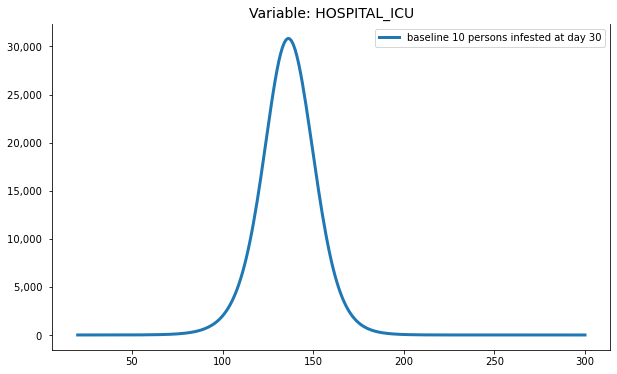

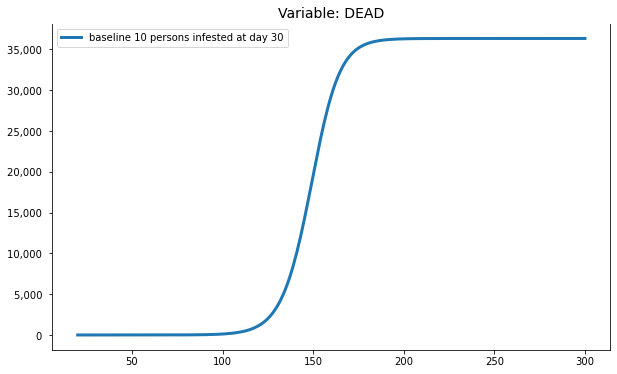

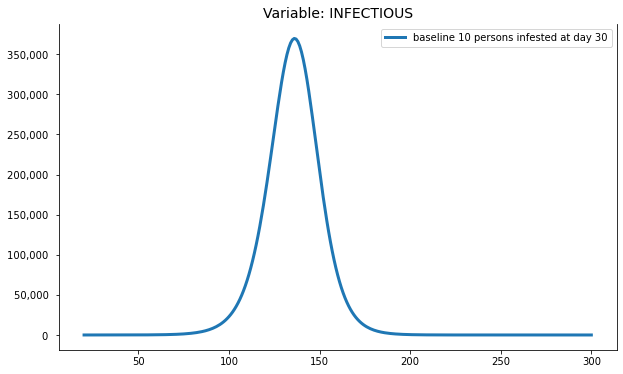

In [23]:
with mcorona.set_smpl(20,300):
    mcorona.keep_plot(' hospital_icu dead infectious',diff=0,legend=1,dec='0')

# Make eksperiments with a range of initial infections
Run and display 

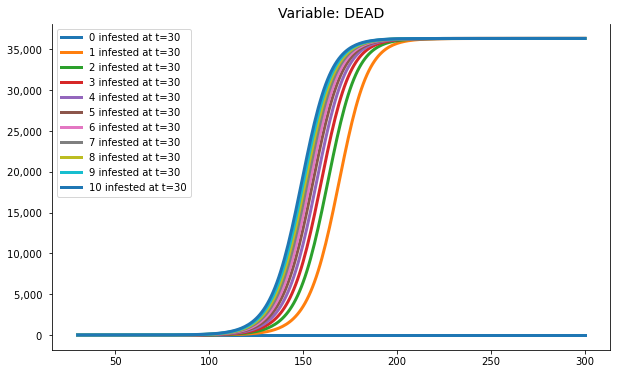

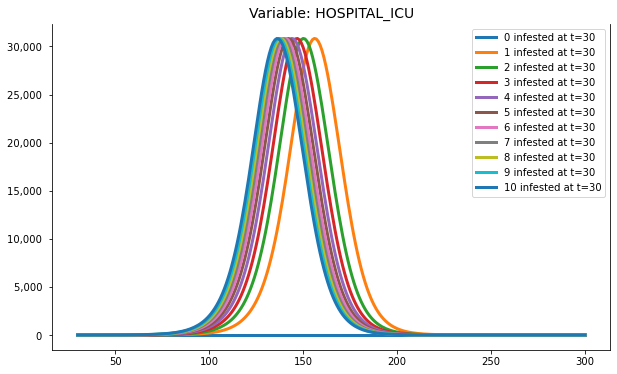

In [24]:
mcorona_infection = model.from_eq(rcorona)     # we make a model instance for this esperiment 
start = 30                                     # Day with infection
for infested in arange(0,11,1):                # Loop over values for number of infested from outside 
    eks = f'EXO_EXPOSED                    = {infested}        {start} {start}'    # Specify the update
    eksdf = model.update_from_list(newdf,eks)                                            # Update the baseline dataframe
    mcorona_infection(eksdf,keep = f'{infested} infested at t={start}');  # Run the model on the updated dataframe

with mcorona_infection.set_smpl(30,300):
    mcorona_infection.keep_plot('dead hospital_icu',diff=0,legend=1,dec='0');

## It can be useful to focus on smaller segments
The next cell allows you to specify the interval you want to see, and the variables you want to display. 

In [25]:
mcorona_infection.keep_viz('DEAD HOSPITAL_ICU')

interactive(children=(IntRangeSlider(value=(20, 200), description='Show interval', layout=Layout(width='75%'),…

# Try different rate of contact

In [26]:
mcorona_rate_contact = model.from_eq(rcorona)     # we make a model instance for this esperiment 
start = 30                                     # Day with infection
for RATE_CONTACT in range(0,11,1):
    eks = f'''
    EXO_EXPOSED                    = 10       {start} {start}
    RATE_CONTACT                   = {RATE_CONTACT}
    '''
    eksdf = model.update_from_list(newdf,eks)
    mcorona_rate_contact(eksdf,keep = f'Rate of contact: {RATE_CONTACT}');

mcorona_rate_contact.keep_viz('DEAD HOSPITAL_ICU')

interactive(children=(IntRangeSlider(value=(20, 200), description='Show interval', layout=Layout(width='75%'),…

# Try different probability of transmission 

In [27]:
mcorona_transmission = model.from_eq(rcorona)     # we make a model instance for this esperiment 
start = 30                                        # Day with infection
for PROBABILITY_TRANSMISION in arange(0.00,0.1,0.01):
    eks = f'''
    EXO_EXPOSED                    = 10       {start} {start}
    RATE_CONTACT                   = 4
    PROBABILITY_TRANSMISION        = {PROBABILITY_TRANSMISION}
    '''
    eksdf = model.update_from_list(newdf,eks)
    mcorona_transmission(eksdf,keep = f'Probability of transmission: {PROBABILITY_TRANSMISION}');

mcorona_transmission.keep_viz('DEAD HOSPITAL_ICU')

interactive(children=(IntRangeSlider(value=(20, 200), description='Show interval', layout=Layout(width='75%'),…

# An interactive interface
We can also use an interactive interface to make experiment.

Try the to change the different input parametres and press **run scenario**. 

In [28]:
# Define user interface 
mcorona.inputwidget(basedf = empty,
                  slidedef = {
'Population            '              :{'var' : 'POPULATION SUSCEPTIBLE', 'min' : 0.0, 'max' : 100_000_000, 'value' : 10_000_000,'step':100_000,'op':'=start-','dec':0},
'Number of infected t=1'              :{'var' : 'EXO_EXPOSED',            'min' : 0.0, 'max' : 1000,       'value' : 1000,      'step':10,'op':'=impulse','dec':0},
'Share of infected with mild symptom' :{'var' : 'NEW_INFECTIOUS_TO_RECOVER_RATE',        'min' : 0.0, 'max' : 1.0,        'value' : 0.1,                'op':'='},
'Share in hospital no ICU and recover':{'var' : 'NEW_HOSPITAL_TO_RECOVER_RATE',          'min' : 0.0, 'max' : 1.0,        'value' : 0.01,               'op':'=' },
'Share in ICU which recovers'         :{'var' : 'NEW_INTENSIVE_TO_RECOVER_RATE',         'min' : 0.0, 'max' : 1.0,        'value' : 0.1,                'op':'='},
'Daily rate of contact'               :{'var' : 'RATE_CONTACT',           'min' : 0.0, 'max' : 30,         'value' : 0,'step':0.1,         'op':'='},
'Probability of transmission'         :{'var' : 'PROBABILITY_TRANSMISION','min' : 0.0, 'max' : 1.0,        'value' : 0.0,'step':0.005,  'op':'=','dec':3},
                             },
                 varpat='infectious recovered dead hospital* *_growth',showvar=True);